In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [2]:
#Load data 
data = pd.read_excel('data/Online Retail.xlsx')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
data_info = pd.DataFrame(data.dtypes).T.rename(index={0:'Column_Type'})
data_info = data_info.append(pd.DataFrame(data.isna().sum()).T.rename(index={0:'Null_values'}))
data_info = data_info.append(pd.DataFrame((data.isna().sum()/data.shape[0])*100).T.rename(index={0:'Null_values%'}))
print(data.shape)
data_info

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
Column_Type,object,object,object,int64,datetime64[ns],float64,float64,object
Null_values,0,0,1454,0,0,0,135080,0
Null_values%,0,0,0.268311,0,0,0,24.9267,0


In [4]:
data.dropna(axis = 0 , subset = ['CustomerID'] , inplace = True)
data_info = pd.DataFrame(data.dtypes).T.rename(index={0:'Column_Type'})
data_info = data_info.append(pd.DataFrame(data.isna().sum()).T.rename(index={0:'Null_values'}))
data_info = data_info.append(pd.DataFrame((data.isna().sum()/data.shape[0])*100).T.rename(index={0:'Null_values%'}))
print(data.shape)
data_info

(406829, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
Column_Type,object,object,object,int64,datetime64[ns],float64,float64,object
Null_values,0,0,0,0,0,0,0,0
Null_values%,0,0,0,0,0,0,0,0


In [5]:
print('Entrées dupliquées: {}'.format(data.duplicated().sum()))
data.drop_duplicates(inplace = True)

Entrées dupliquées: 5225


25% of the CustomerID is missing , we cant impute these type of data since it can describe different type of customers so the only remedy that we can do here is to remove them , on the other hand the Description variable have only 0.27% of the missing values , we could ignore these missing values since the other information on the row are more valuable than the description of the customer 

there is also a number of duplicates in the data that we should remove them all , even if a customer ordered multiple times he should have distinct invoiceNo for each order and each Invoice number should have unique product , hence they should be no duplicates on the database 

## 2. Exploring the content of variables

This dataframe contains 8 variables that correspond to: 

**InvoiceNo**: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.  <br>
**StockCode**: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. <br>
**Description**: Product (item) name. Nominal. <br>
**Quantity**: The quantities of each product (item) per transaction. Numeric.	<br>
**InvoiceDate**: Invice Date and time. Numeric, the day and time when each transaction was generated. <br>
**UnitPrice**: Unit price. Numeric, Product price per unit in sterling. <br>
**CustomerID**: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. <br>
**Country**: Country name. Nominal, the name of the country where each customer resides.<br>

#### 2.1 Countries 


In [6]:
print('Number of unique countries : ' , len(data.Country.unique()))

Number of unique countries :  37


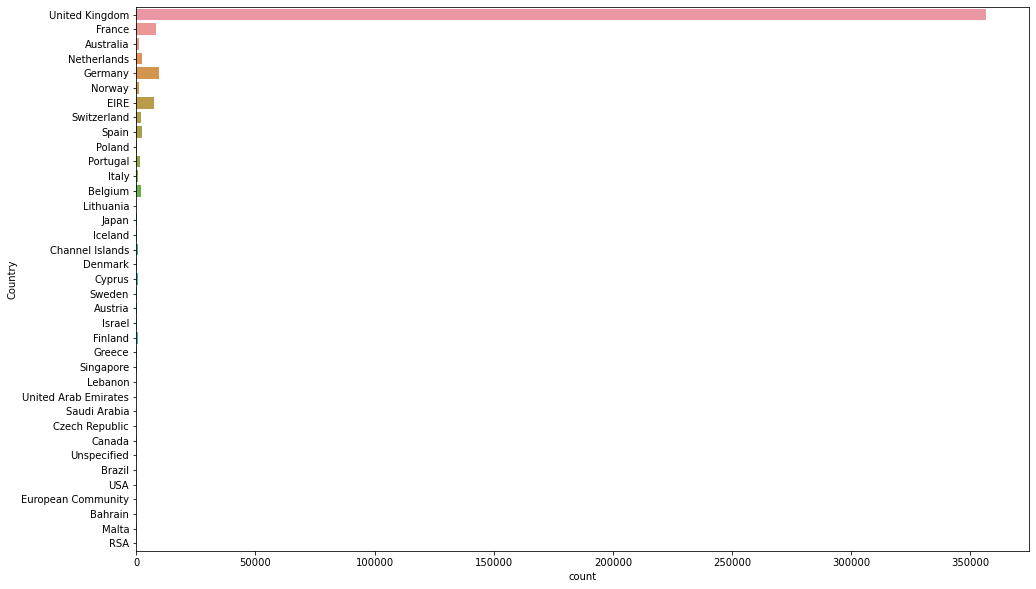

In [7]:
fig , ax = plt.subplots(1,1 , figsize=(16,10))
sns.countplot(y = data.Country , ax = ax )

Uk take the lead with the most number of orders made which makes it more likely to be the center of the firm the data is taken from and the hot spot for the business

#### 2.2 Custumers and transactions

In [8]:
Cus_info = pd.DataFrame({
    'products' : len(data.StockCode.unique()),
    'transactions' : len(data.InvoiceNo.unique()),
    'Customers' : len(data.CustomerID.unique())
} , index=['quantity'])
Cus_info

,products,transactions,Customers
quantity,3684,22190,4372


It can be seen that the data concern 4372 users and that they bought 3684 different products. The total number of transactions carried out is of the order of  ∼ 22'000.

Now I will determine the number of products purchased in every transaction:

In [9]:
data[['CustomerID' , 'InvoiceNo' ,'StockCode' ]].groupby(['CustomerID' , 'InvoiceNo']).count()

StockCode
CustomerID InvoiceNo           
12346.0    541431             1
           C541433            1
12347.0    537626            31
           542237            29
           549222            24
...                         ...
18283.0    579673            50
           580872            50
18287.0    554065            29
           570715            38
           573167             3

[22190 rows x 1 columns]

we can see that a customer can order one products or many at a time , now we need to analyse the canceled order and see if there is a specific pattern 

In [10]:
mask = data[['InvoiceNo']].apply(
    lambda x : x.str.contains('C.*' , regex = True)
).any(axis=1)
print(len(data[mask].InvoiceNo.unique()) / len(data.InvoiceNo.unique()))
data[mask].head()


0.16466876971608832


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


we can distinguish the canceled orders by the C letter at beginning of the invoice number and also the negative number of the quantity which regesters the quantity of product that have been canceled . 

16% of the ordered are canceled . 

we can make two hypothesis out of this information , first we can say that every order canceled have its own counterpart  , or not every orde canceled have its own counterpart since the order could be made before the data been drawn 

In [11]:
df_check = data[data['Quantity'] < 0][['CustomerID','Quantity',
                                                   'StockCode','Description','UnitPrice']]

for index, col in  df_check.iterrows():
    if data[(data['CustomerID'] == col[0]) & (data['Quantity'] == -col[1]) 
            & (data['Description'] == col[2])].shape[0] == 0: 
        print(df_check.loc[index])
        print(15*'-'+'>'+' First HYPOTHESIS NOT FULFILLED')
        break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
---------------> First HYPOTHESIS NOT FULFILLED


the failed to reject the second hypothesis which mean that not every canceled order have a counterpart.


to make things clear there is three kind of orders in the dataset :

- orders that had been canceled but there counterpart doesnt exist in the data 
- orders that had been canceled and there counterpart exist 
- orders that havent been canceled 

we will devide the orders into those three part . 

In [12]:
 trigger = False
if trigger == False : 
    df_cleaned = data.copy(deep = True)
    df_cleaned['QuantityCanceled'] = 0

    with_count = [] ; without_count = []

    for index , col in data.iterrows():
        if (col['Quantity'] > 0) or (col['Description'] == 'Discount') : continue
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                      (data['StockCode'] == col['StockCode']) &
                      (data['InvoiceDate'] < col['InvoiceDate']) &
                       (data['Quantity'] > 0 )
                      ].copy()

        if df_test.shape[0] == 0 :
            without_count.append(index)
        elif df_test.shape[0] == 1:
            with_count.append(index)
            index_order = df_test.index[0]
            df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        elif df_test.shape[0] > 1:
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)
            for ind , var in df_test.iterrows():
                if var['Quantity'] < -col['Quantity'] : continue
                df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
                with_count.append(index)



In [13]:
df_cleaned.drop(with_count, axis = 0, inplace = True)
df_cleaned.drop(without_count, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("nb of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

nb of entries to delete: 48


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
77598,C542742,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,-94,2011-01-31 16:26:00,0.65,15358.0,United Kingdom,0
90444,C544038,22784,LANTERN CREAM GAZEBO,-4,2011-02-15 11:32:00,4.95,14659.0,United Kingdom,0
111968,C545852,22464,HANGING METAL HEART LANTERN,-5,2011-03-07 13:49:00,1.65,14048.0,United Kingdom,0
116064,C546191,47566B,TEA TIME PARTY BUNTING,-35,2011-03-10 10:57:00,0.70,16422.0,United Kingdom,0
132642,C547675,22263,FELT EGG COSY LADYBIRD,-49,2011-03-24 14:07:00,0.66,17754.0,United Kingdom,0


In [14]:
data[(data.CustomerID == 15358 )&(data.StockCode == '84535B')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
19719,537888,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,16,2010-12-09 10:04:00,0.65,15358.0,United Kingdom
44629,540187,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,16,2011-01-05 13:53:00,0.65,15358.0,United Kingdom
72849,542268,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,16,2011-01-27 08:30:00,0.65,15358.0,United Kingdom
77598,C542742,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,-94,2011-01-31 16:26:00,0.65,15358.0,United Kingdom


After dropping the canceled orders with and without counterparts we observe another kind of cancelation which have a counterpart but the quantity canceled is greater than the sum of all quantities ordered in this data which mean that maybe some of the quantities canceled are from the ones ordered in the data or they are all belongs to orders made before

#### 2.3 Stock Code 

In [15]:
codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+',regex=True , na=False)]['StockCode'].unique()
codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

In [16]:
for i in codes : 
    unique = df_cleaned.Description[df_cleaned.StockCode == i].unique()[0]
    print(f'{i} --> {unique}')

POST --> POSTAGE
D --> Discount
C2 --> CARRIAGE
M --> Manual
BANK CHARGES --> Bank Charges
PADS --> PADS TO MATCH ALL CUSHIONS
DOT --> DOTCOM POSTAGE


There is a special character in stock code indicating a special kind of transactions made for example D is for discount for some customers 

#### 2.3 exploring the price and analysing the price Basket  

In [17]:
df_cleaned['Total_Price'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'] )
df_cleaned

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,Total_Price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34
...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,0,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,0,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,0,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,0,16.60


lets calculate the prices for orders made by a single customer 

In [18]:
X = df_cleaned[['CustomerID' , 'InvoiceNo' , 'Total_Price' , 'InvoiceDate']].copy()
X = X.groupby(['CustomerID' , 'InvoiceNo' ,'InvoiceDate']).sum().reset_index()
X.rename(columns = {'Total_Price' : 'Price_Basket'} , inplace= True)
X[X.CustomerID == 12347 ]


,CustomerID,InvoiceNo,InvoiceDate,Price_Basket
1,12347.0,537626,2010-12-07 14:57:00,711.79
2,12347.0,542237,2011-01-26 14:30:00,475.39
3,12347.0,549222,2011-04-07 10:43:00,636.25
4,12347.0,556201,2011-06-09 13:01:00,382.52
5,12347.0,562032,2011-08-02 08:48:00,584.91
6,12347.0,573511,2011-10-31 12:25:00,1294.32
7,12347.0,581180,2011-12-07 15:52:00,224.82


In [19]:
price_ranges = [0 , 100 ,200 , 500 , 700 , 900 , 1000 ]
price_basket = {}
price_basket['0>.'] = X[(X['Price_Basket'] == 0)]['Price_Basket'].count()
for i , price in enumerate(price_ranges):
    if i == 0 : continue
    val = X[(X['Price_Basket'] < price) & (X['Price_Basket'] < price_ranges[i-1])]['Price_Basket'].count()
    price_basket[f'{price_ranges[i-1]}<.<{price}'] = val

price_basket['.>1000'] = X[(X['Price_Basket'] > 1000)]['Price_Basket'].count()
price_basket

{'0>.': 168,
 '0<.<100': 98,
 '100<.<200': 2529,
 '200<.<500': 6555,
 '500<.<700': 14630,
 '700<.<900': 16314,
 '900<.<1000': 17178,
 '.>1000': 1236}

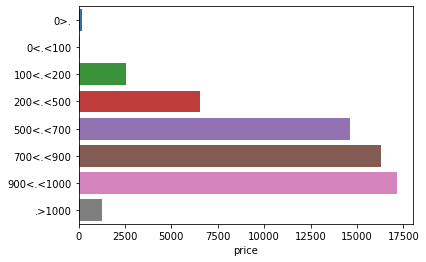

In [20]:
ranges = pd.DataFrame(price_basket , index = ['price']).T
sns.barplot(y = ranges.index , x = ranges.price)

most customers spend total between 500 and 1000 

### 2.4 Exploring the order time

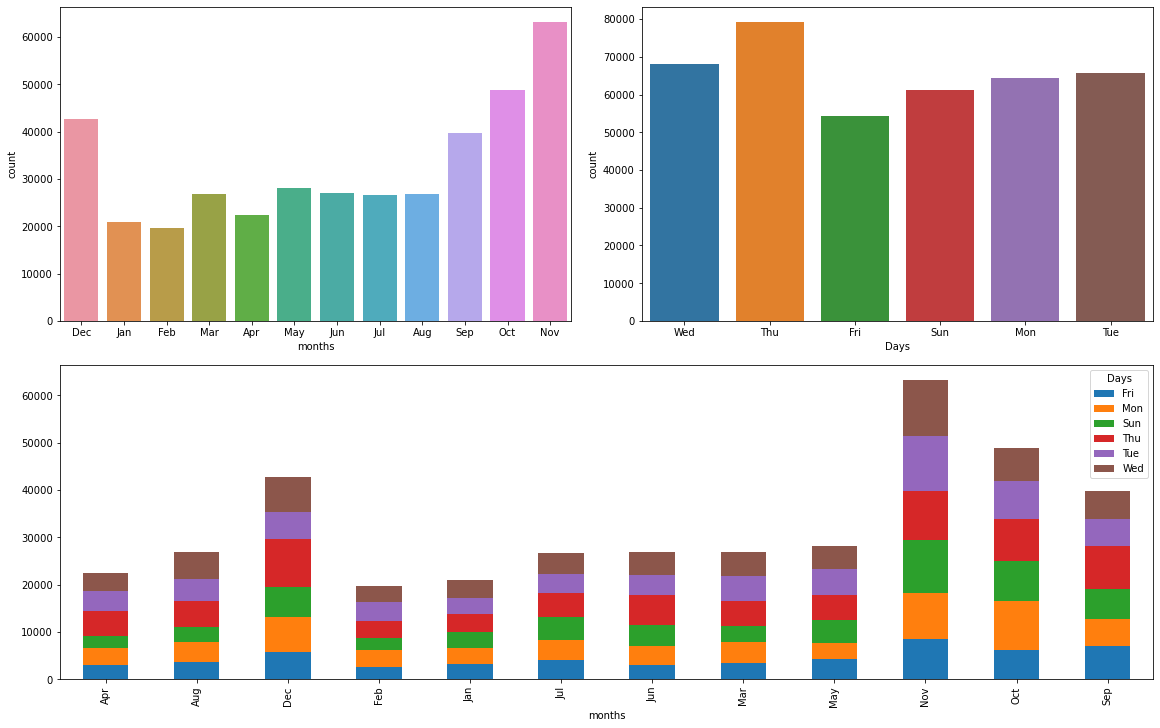

In [163]:
X = df_cleaned[['CustomerID' , 'Total_Price' , 'InvoiceDate']].copy()
X['months'] = X['InvoiceDate'].dt.strftime('%b')
X['Days'] = X['InvoiceDate'].dt.strftime('%a')
X_ = X.groupby(['months', 'Days']).size().reset_index().pivot(columns='Days', index='months', values=0)

#_________________________________
fig = plt.figure(figsize = (16 ,10 ) , constrained_layout = True)
gs = fig.add_gridspec(2 , 2)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,:])

sns.countplot(X['months'] , ax = ax1 )
sns.countplot( X['Days'] , ax = ax2)
X_.plot(kind = 'bar' , stacked = True ,  ax = ax3)

The mean observation here is that there is no transactions on saturday , and the number of transactions increases in the last 4 months from Sep to Dec 

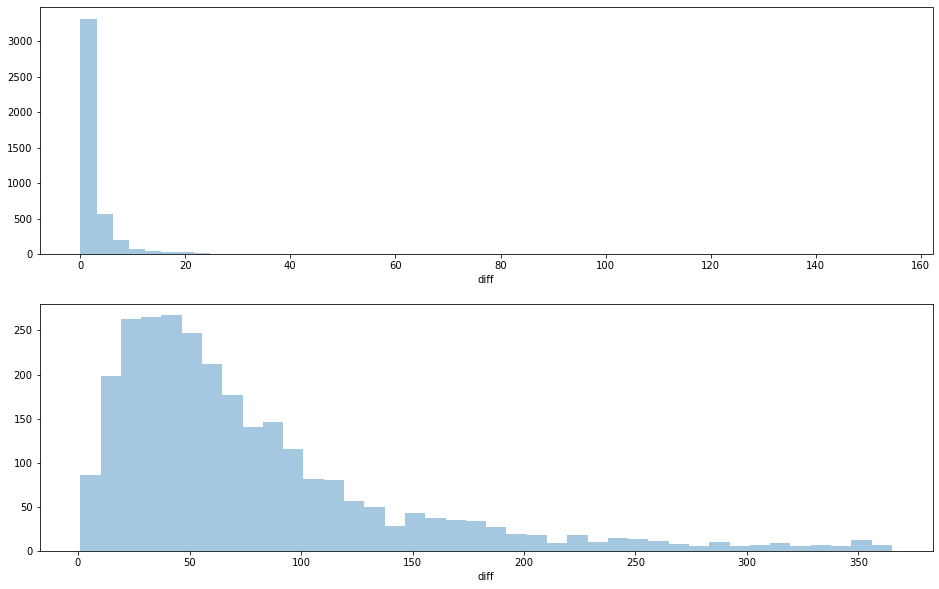

In [167]:
# X['diff'] = X[['CustomerID' , 'InvoiceDate']].groupby('CustomerID')['InvoiceDate'].diff().fillna(pd.Timedelta(seconds=0))
# X['diff']=X['diff'].apply(lambda x : x.days)
# y = X[(X['diff'] != 0)][['CustomerID' , 'diff']].groupby('CustomerID').mean()
y_ = X[['CustomerID' , 'diff']].groupby('CustomerID').mean()
fig , ax = plt.subplots(2,1,figsize=(16,10))
sns.distplot(y['diff'] , hist=True , kde=False , ax = ax[1])
sns.distplot(y_['diff'] , hist=True , kde=False  , ax = ax[0])

these plots shows the difference between the last transaction of a customer and the new one he made in days , the first plot shows us the huge amount of customers that only ordered once and never ordered again , in the second plot we filtered the 0 days difference and keep the others so we now have the distribution of custumers who came back for another order after the last one  and difference between does two orders in days 

In [165]:
X['dates'] = X['InvoiceDate']
X['dates'] = X['dates'].apply(
    lambda x : '{}-{}-01'.format(x.strftime('%Y') ,x.strftime('%m')) )
X.head()

,CustomerID,Total_Price,InvoiceDate,months,Days,diff,dates
0,17850.0,15.30,2010-12-01 08:26:00,Dec,Wed,0,2010-12-01
1,17850.0,20.34,2010-12-01 08:26:00,Dec,Wed,0,2010-12-01
2,17850.0,22.00,2010-12-01 08:26:00,Dec,Wed,0,2010-12-01
3,17850.0,20.34,2010-12-01 08:26:00,Dec,Wed,0,2010-12-01
4,17850.0,20.34,2010-12-01 08:26:00,Dec,Wed,0,2010-12-01


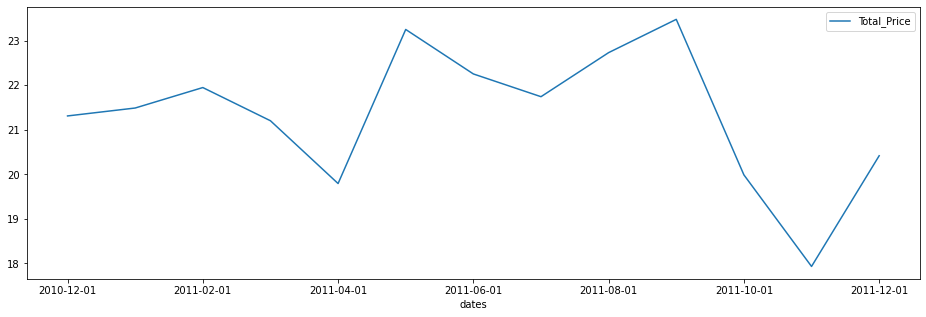

In [162]:
ts = X[['dates' , 'Total_Price']].groupby('dates').mean()
ts.plot()

here is a time series plot representing the mean of sales made of each month of this year , indecating three major increases each one of them is followed by a major decrease , we can interpret this as a seasonal pattern , to see that we need to study weekly and quartly data 

In [8]:
X = pd.read_csv('data/basket_price.csv' , index_col=['Unnamed: 0'])

In [9]:
X

,CustomerID,Total_Price,InvoiceDate,months,Days,diff,dates
0,17850.0,15.30,2010-12-01 08:26:00,Dec,Wed,0,2010-12-01
1,17850.0,20.34,2010-12-01 08:26:00,Dec,Wed,0,2010-12-01
2,17850.0,22.00,2010-12-01 08:26:00,Dec,Wed,0,2010-12-01
3,17850.0,20.34,2010-12-01 08:26:00,Dec,Wed,0,2010-12-01
4,17850.0,20.34,2010-12-01 08:26:00,Dec,Wed,0,2010-12-01
...,...,...,...,...,...,...,...
541904,12680.0,10.20,2011-12-09 12:50:00,Dec,Fri,0,2011-12-01
541905,12680.0,12.60,2011-12-09 12:50:00,Dec,Fri,0,2011-12-01
541906,12680.0,16.60,2011-12-09 12:50:00,Dec,Fri,0,2011-12-01
541907,12680.0,16.60,2011-12-09 12:50:00,Dec,Fri,0,2011-12-01


In [24]:
weekly_data = X[['InvoiceDate' , 'Total_Price']].copy()
weekly_data['InvoiceDate'] = pd.to_datetime(X.InvoiceDate)
# weekly_data['dates'] = weekly_data['InvoiceDate'].dt.strftime('%x')

# weekly_data['dates'] = pd.to_datetime(weekly_data['dates'])

output = weekly_data[['InvoiceDate' , 'Total_Price']].set_index(['InvoiceDate']).resample('W',                                 # Weekly resample
                      
                     loffset=pd.offsets.DateOffset(days=-6)).apply({'Total_Price' : 'sum'})  # to put the labels to Monday


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  if __name__ == '__main__':


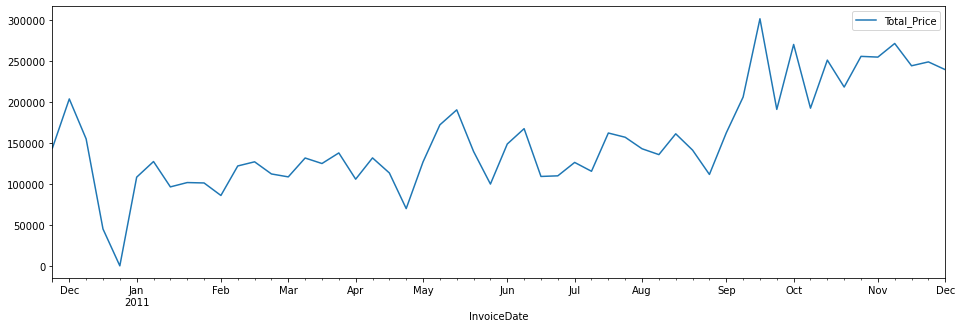

In [35]:
output.plot(figsize = (16,5))

displaying the weekly data we can see an uprise trend but no clear evidence for seasonality 